In [1]:
# Import statements

import MySQLdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score 

from HTMLParser import HTMLParser
import htmlentitydefs
import itertools
import re
import datetime

import sys

%matplotlib inline

# Importing Database

In [2]:
# Create database object

db = MySQLdb.connect("localhost", "root", "", "junglescene")

In [3]:
# Create database cursor object

cursor = db.cursor()

In [4]:
cursor.execute("SHOW TABLES")

128L

In [5]:
cursor.fetchall()

(('ImageGroups',),
 ('Images',),
 ('action',),
 ('active_banners',),
 ('address',),
 ('articles',),
 ('artists',),
 ('artistsgroup',),
 ('attending',),
 ('banned',),
 ('banners',),
 ('bushism',),
 ('calendar',),
 ('cardscards',),
 ('cardscategories',),
 ('cardspersonal',),
 ('cart',),
 ('chatters',),
 ('cms',),
 ('colors',),
 ('comments',),
 ('commentstopics1',),
 ('commentstopics2',),
 ('content',),
 ('country',),
 ('cutype',),
 ('date',),
 ('date_model',),
 ('day',),
 ('donations',),
 ('events',),
 ('forums',),
 ('forumstopics1',),
 ('forumstopics100',),
 ('forumstopics101',),
 ('forumstopics103',),
 ('forumstopics106',),
 ('forumstopics107',),
 ('forumstopics109',),
 ('forumstopics122',),
 ('forumstopics123',),
 ('forumstopics124',),
 ('forumstopics125',),
 ('forumstopics126',),
 ('forumstopics127',),
 ('forumstopics128',),
 ('forumstopics129',),
 ('forumstopics130',),
 ('forumstopics132',),
 ('forumstopics135',),
 ('forumstopics136',),
 ('forumstopics137',),
 ('forumstopics138',),


In [6]:
# Create forumsdata DataFrame. forumsdata is all the collected posts from several of the Junglescene database forums.
# Data comes from all forums with over 10000 posts. These forums are: Jungle Scene, Clubs & Parties, Photos, Producing,
# Neptune For Poetry, Hip Hop, Party Reviews, General Discussion, Ragga, Dubstep, Sets & Tracklistings, and 
# Dancer's Corner. 

# Create DataFrame column names for the forumsdata DataFrame

table_cols = ['tid', 'pid', 'rid', 'children', 'subject', 'body', 'username', 
              'user_addr', 'mailreply', 'rank', 'status', 'modified', 'created', 
              'lastip', 'userstatus', 'closed', 'forum_id']

# Create list of sql forum table names
forumtablenames = ['forumstopics1', 'forumstopics2', 'forumstopics122', 'forumstopics9', 'forumstopics40', 
                   'forumstopics30', 'forumstopics63', 'forumstopics137', 'forumstopics25', 'forumstopics130', 
                  'forumstopics125','forumstopics44']

# Create list of forum id from sql. These will mark the posts in the forumsdata DataFrame so their origin is known.
forumid = [1,2,122,9,40,30,63,137,25,130,125,44]

# Create empty DataFrame
forumsdata = pd.DataFrame(columns=table_cols)


# Create forumsdata
for tn,fid in zip(forumtablenames, forumid):
    cursor.execute("select * from {}".format(tn))
    data = cursor.fetchall()

    temp_forum = pd.DataFrame(list(data))
    temp_forum['forum_id'] = fid
    temp_forum.columns = table_cols
    
    forumsdata = forumsdata.append(temp_forum)
    
forumsdata.reset_index(inplace=True)


# Cleaning, Analysis, Feature Engineering

In [7]:
# Separating time information

forumsdata['modifiedyear'] = forumsdata['modified'].dt.year
forumsdata['modifiedmonth'] = forumsdata['modified'].dt.month
forumsdata['modifiedday'] = forumsdata['modified'].dt.day
forumsdata['modifiedhour'] = forumsdata['modified'].dt.hour
forumsdata['modifiedminute'] = forumsdata['modified'].dt.minute
forumsdata['modifiedsecond'] = forumsdata['modified'].dt.second

forumsdata['createdyear'] = forumsdata['created'].dt.year
forumsdata['createdmonth'] = forumsdata['created'].dt.month
forumsdata['createdday'] = forumsdata['created'].dt.day
forumsdata['createdhour'] = forumsdata['created'].dt.hour
forumsdata['createdminute'] = forumsdata['created'].dt.minute
forumsdata['createdminute'] = forumsdata['created'].dt.minute
forumsdata['createdsecond'] = forumsdata['created'].dt.second

forumsdata.head()

,index,tid,pid,rid,children,subject,body,username,user_addr,mailreply,...,modifiedday,modifiedhour,modifiedminute,modifiedsecond,createdyear,createdmonth,createdday,createdhour,createdminute,createdsecond
0,0,1.0,1.0,1.0,23.0,ok i cleared this forum out... so...,start it up again peeps.<br />\r\n<br />\r\n-dave,eecue,208.179.230.93,0.0,...,8,1,39,40,2002,7,8,12,2,56
1,1,2.0,1.0,1.0,0.0,Re: ok i cleared this forum out... so...,ouch!,mudda,208.46.145.162,0.0,...,8,12,4,18,2002,7,8,12,4,18
2,2,3.0,3.0,3.0,4.0,Boo fucking Hoo...,No more Monday night coffee shop drum 'n' bass...,kryptic,68.96.64.212,0.0,...,8,18,54,1,2002,7,8,12,13,24
3,3,4.0,3.0,3.0,1.0,Re: Boo fucking Hoo...,<img src=http://junglescene.com/img/sad.gif b...,raggamffn,66.88.157.226,0.0,...,8,12,29,39,2002,7,8,12,13,52
4,4,5.0,1.0,1.0,1.0,Re: ok i cleared this forum out... so...,!!!!!!arghhhhhhhh,sara,209.204.144.242,0.0,...,8,12,16,17,2002,7,8,12,14,10


In [112]:
forumsdata.shape

(663566, 24)

In [8]:
forumsdata['subject'] = forumsdata['subject'].str.replace('Re: ', '')
forumsdata.head()

,index,tid,pid,rid,children,subject,body,username,user_addr,mailreply,...,modifiedday,modifiedhour,modifiedminute,modifiedsecond,createdyear,createdmonth,createdday,createdhour,createdminute,createdsecond
0,0,1.0,1.0,1.0,23.0,ok i cleared this forum out... so...,start it up again peeps.<br />\r\n<br />\r\n-dave,eecue,208.179.230.93,0.0,...,8,1,39,40,2002,7,8,12,2,56
1,1,2.0,1.0,1.0,0.0,ok i cleared this forum out... so...,ouch!,mudda,208.46.145.162,0.0,...,8,12,4,18,2002,7,8,12,4,18
2,2,3.0,3.0,3.0,4.0,Boo fucking Hoo...,No more Monday night coffee shop drum 'n' bass...,kryptic,68.96.64.212,0.0,...,8,18,54,1,2002,7,8,12,13,24
3,3,4.0,3.0,3.0,1.0,Boo fucking Hoo...,<img src=http://junglescene.com/img/sad.gif b...,raggamffn,66.88.157.226,0.0,...,8,12,29,39,2002,7,8,12,13,52
4,4,5.0,1.0,1.0,1.0,ok i cleared this forum out... so...,!!!!!!arghhhhhhhh,sara,209.204.144.242,0.0,...,8,12,16,17,2002,7,8,12,14,10


In [9]:
# Number of threads closed

len(forumsdata[forumsdata['closed']==1]['subject'].unique())

215

In [10]:
# Number of threads open

len(forumsdata[forumsdata['closed']==0]['subject'].unique())

89059

In [11]:
# There is a discrepency between the closed and not closed topics. I think there are some threads with the same subject
# that are marked as closed, and as open. I.E. some posts in the same subject were marked closed and others as open.

len(forumsdata['subject'].unique())

89256

In [12]:
89059+215

89274

In [13]:
# It looks like there are 18 of these threads

89274-89256

18

In [14]:
# Set of closed subjects
closed_subjects = set(forumsdata[forumsdata['closed']==1]['subject'].unique())

# Set of open subjects
open_subjects = set(forumsdata[forumsdata['closed']==0]['subject'].unique())

# List of subjects where thread is marked as both closed and open
duplicate_closedopen = list(set.intersection(closed_subjects, open_subjects))

In [15]:
# Subject titles for threads with both closed and open designations

duplicate_closedopen

['Bullet Proof Week 2',
 'WTF?',
 'This Battle',
 "ATTENTION MC'S",
 'please read',
 "RESPECT 1.20.05::RID'EM RECORD RELEASE::",
 '.',
 'DRAMA',
 '\xe2\x80\x9cFreedom Is Not Free\xe2\x80\x9d propaganda',
 'more fun facts',
 "this site is not paying for it's self...",
 'Grapevinez Invites Temple Of Boom',
 'Bullet Proof',
 'FUNKTION ONE YEAR FEAT. SIMON BASSLINE SMITH // 01.24.07',
 'Dillinja - Feel My Pain',
 'Elevate - 08.06.05 - Indoor/Outdoor DnB Loft Party',
 'Evol_Intent_-_Exclusive_Dnbradio_Broadcast_18-08-2004',
 'why was my John Dada thread closed??']

In [16]:
# Deleting threads marked both closed and open

sizeb4 = forumsdata.size
print 'Number of posts Before: ', sizeb4

for x in duplicate_closedopen:
    dup_idx = forumsdata[forumsdata['subject']==x].index
    forumsdata = forumsdata.drop(dup_idx)
    
sizeafter = forumsdata.size
print 'Number of posts after: ', sizeafter
print 'Number of posts deleted: ', sizeb4-sizeafter

Number of posts Before:  20130840
Number of posts after:  20112990
Number of posts deleted:  17850


In [17]:
# Verify threads marked both closed/open are gone

# Set of closed subjects
closed_subjects = set(forumsdata[forumsdata['closed']==1]['subject'].unique())

# Set of open subjects
open_subjects = set(forumsdata[forumsdata['closed']==0]['subject'].unique())

# List of subjects where thread is marked as both closed and open
duplicate_closedopen = list(set.intersection(closed_subjects, open_subjects))
duplicate_closedopen

[]

In [18]:
forumsdata.describe()

,index,tid,pid,rid,children,mailreply,rank,status,closed,forum_id,...,modifiedday,modifiedhour,modifiedminute,modifiedsecond,createdyear,createdmonth,createdday,createdhour,createdminute,createdsecond
count,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,...,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000,670433.000000
mean,77382.018506,78471.677774,78348.168561,77953.079757,1.597356,0.003750,2.223074,0.940753,0.004873,22.372174,...,15.603327,13.763568,29.566975,29.513656,2005.165487,6.620805,15.565985,13.675726,29.544608,29.509335
std,69721.572297,70900.323529,70842.949618,70681.138270,5.593619,0.061121,3.880633,0.247745,0.069636,39.360621,...,8.730886,5.172671,17.343581,17.312043,2.653514,3.451718,8.730512,5.157214,17.311004,17.328463
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,2001.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,14703.000000,14868.000000,14809.000000,14645.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,...,8.000000,11.000000,15.000000,15.000000,2003.000000,4.000000,8.000000,11.000000,15.000000,14.000000
50%,52797.000000,53300.000000,53132.000000,52596.000000,1.000000,0.000000,3.000000,1.000000,0.000000,2.000000,...,15.000000,14.000000,30.000000,30.000000,2005.000000,7.000000,15.000000,14.000000,30.000000,30.000000
75%,136723.000000,138655.000000,138468.000000,137619.000000,1.000000,0.000000,3.000000,1.000000,0.000000,30.000000,...,23.000000,17.000000,45.000000,44.000000,2007.000000,10.000000,23.000000,17.000000,45.000000,44.000000
max,232382.000000,236985.000000,236985.000000,236985.000000,1215.000000,1.000000,3073.000000,62.000000,1.000000,137.000000,...,31.000000,23.000000,59.000000,59.000000,2016.000000,12.000000,31.000000,23.000000,59.000000,59.000000


In [19]:
# Look at example of body text. We can see it's got all kind of special characters we need to remove.

forumsdata['body'][12]

'wow, TS & Dillinja & Lemon D!!!..<br />\r\n<br />\r\ni am so going to this party.....!!!!!!'

In [20]:
# Clean up body text

# Class to help parse html within a body of text

class HTMLTextExtractor(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.result = [ ]

    def handle_data(self, d):
        self.result.append(d)

    def handle_charref(self, number):
        codepoint = int(number[1:], 16) if number[0] in (u'x', u'X') else int(number)
        self.result.append(unichr(codepoint))

    def handle_entityref(self, name):
        codepoint = htmlentitydefs.name2codepoint[name]
        self.result.append(unichr(codepoint))

    def get_text(self):
        return u''.join(self.result)

# Function to call to use HTMLTextExtractor Class

def html_to_text(html):
    # Set up HTMLTextExtractor object and send for processing
    s = HTMLTextExtractor()
    s.feed(html)
    return s.get_text()
    
def clean_string(string):
    
    # Dictionary used to help remove extra characters HTMLTextExtractor did not get
    dict = {'\\r':' ','\\n':' ','\n':' ','\r':' ','\u':' ','\\':' ','/':' ', '@':' ', '.':' ',
            '?':' ','-':' ','!':' ',',':' ',':':' ','[':' ',']':' ', '(':' ', ')':' ','\"':' ',
            '\'':'', '#':' ','~':' ', '&':''}
    
    # Remove characters from dict
    for i,j in dict.iteritems():
         string = string.replace(i,j)
            
    #Remove html using html_to_text
    string = html_to_text(string)
            
    # Remove some Unicode punctuation
    string = re.sub(r"\u2019",'',string)

    # Remove URLs
    string = re.sub(r"http\S+", "link", string)
    
    # Remove edit tags
    string = string.split('*$$ ')[0]
    
    # Return the super clean string
    return string.encode('ascii', 'ignore')


In [21]:
clean_post=[]
for post in forumsdata['body']:
    try:
        clean_post.append(clean_string(post.decode('utf-8')))
    except:
        e = sys.exc_info()[0]
        clean_post.append(str(e))

forumsdata['body'] = clean_post

In [22]:
forumsdata.head()

,index,tid,pid,rid,children,subject,body,username,user_addr,mailreply,...,modifiedday,modifiedhour,modifiedminute,modifiedsecond,createdyear,createdmonth,createdday,createdhour,createdminute,createdsecond
0,0,1.0,1.0,1.0,23.0,ok i cleared this forum out... so...,start it up again peeps dave,eecue,208.179.230.93,0.0,...,8,1,39,40,2002,7,8,12,2,56
1,1,2.0,1.0,1.0,0.0,ok i cleared this forum out... so...,ouch,mudda,208.46.145.162,0.0,...,8,12,4,18,2002,7,8,12,4,18
2,2,3.0,3.0,3.0,4.0,Boo fucking Hoo...,No more Monday night coffee shop drum n bass ...,kryptic,68.96.64.212,0.0,...,8,18,54,1,2002,7,8,12,13,24
3,3,4.0,3.0,3.0,1.0,Boo fucking Hoo...,,raggamffn,66.88.157.226,0.0,...,8,12,29,39,2002,7,8,12,13,52
4,4,5.0,1.0,1.0,1.0,ok i cleared this forum out... so...,arghhhhhhhh,sara,209.204.144.242,0.0,...,8,12,16,17,2002,7,8,12,14,10


In [23]:
# Clean body text!

forumsdata['body'][13840]

'i have one that i put together in August entitled systemError  if youd like a copy  hit me up on the jsm     SD TJ'

In [24]:
# Getting rid of features that don't make sense as predictors

del_cols = ['tid', 'pid', 'rid', 'children', 'user_addr', 'mailreply', 'lastip']

forumsdata = forumsdata.drop(del_cols, axis = 1)
forumsdata.head()

,index,subject,body,username,rank,status,modified,created,userstatus,closed,...,modifiedday,modifiedhour,modifiedminute,modifiedsecond,createdyear,createdmonth,createdday,createdhour,createdminute,createdsecond
0,0,ok i cleared this forum out... so...,start it up again peeps dave,eecue,3.0,1.0,2009-09-08 01:39:40,2002-07-08 12:02:56,administrator,0.0,...,8,1,39,40,2002,7,8,12,2,56
1,1,ok i cleared this forum out... so...,ouch,mudda,3.0,1.0,2002-07-08 12:04:18,2002-07-08 12:04:18,respected junglist,0.0,...,8,12,4,18,2002,7,8,12,4,18
2,2,Boo fucking Hoo...,No more Monday night coffee shop drum n bass ...,kryptic,2.0,1.0,2002-07-08 18:54:01,2002-07-08 12:13:24,respected junglist,0.0,...,8,18,54,1,2002,7,8,12,13,24
3,3,Boo fucking Hoo...,,raggamffn,3.0,1.0,2002-07-08 12:29:39,2002-07-08 12:13:52,yardie mon,0.0,...,8,12,29,39,2002,7,8,12,13,52
4,4,ok i cleared this forum out... so...,arghhhhhhhh,sara,3.0,1.0,2002-07-08 12:16:17,2002-07-08 12:14:10,power user,0.0,...,8,12,16,17,2002,7,8,12,14,10


In [25]:
# Eliminate posts with empty bodys. Most likely these were posts made up entirely of html. There were only ~7000 posts
# like this, of which only 65 were from closed threads.

forumsdata = forumsdata.drop(forumsdata[forumsdata['body']==''].index)
forumsdata = forumsdata.drop(forumsdata[forumsdata['subject']==''].index)

In [26]:
forumsdata[forumsdata['subject']=='']

,index,subject,body,username,rank,status,modified,created,userstatus,closed,...,modifiedday,modifiedhour,modifiedminute,modifiedsecond,createdyear,createdmonth,createdday,createdhour,createdminute,createdsecond


In [27]:
# Top posters in closed threads

forumsdata[forumsdata['closed']==1]['username'].value_counts()

eecue               222
unifire             116
broken_records       74
kellyd               37
piston22             36
bring_the_rukus      36
circuit              33
djdmt                30
world.renowned       27
uniteddnb            26
djcalculon           26
aero                 25
zona                 25
jos                  25
melicious            25
dublg                25
djunit               24
aurakul              24
mainframe            23
step_correct         23
thepoet              22
peteg2               22
krezrock             22
mandy                21
outsource            20
mc.xyz               19
stikygreen2001       18
teekay               18
twotokes             18
t3___                18
                   ... 
djmurdok              1
drumaddict            1
clutch                1
subsequence           1
sida                  1
outletdnb             1
psidream              1
candyce.              1
needledamage          1
shawnliu              1
muddy_mudskipper

In [28]:
# Top posters in open threads
forumsdata[forumsdata['closed']==0]['username'].value_counts()

unifire            7654
mc.xyz             6774
aurakul            6670
eecue              6606
djcalculon         6134
djdmt              5314
kellyd             5077
thepoet            4643
uniteddnb          4240
djkgb              4181
teekay             3733
world.renowned     3649
themenace          3582
circuit            3554
dj.com             3233
melicious          3182
magnafide          3152
jos                3126
missanita          3116
slapinfunk         3111
chrisk             3107
probable_cause     3104
mainframe          3076
alan               3075
aero               3067
blaze13            2989
misundastood       2943
jigsaw             2895
broken_records     2837
zona               2835
                   ... 
jimturns              1
pandacutie            1
preshacrew            1
geist                 1
redarmyaudio          1
candikane             1
grumpydeacon          1
leelou                1
newpuppygallery       1
showstoppa            1
kicksdirt       

In [29]:
# Top posters in all threads
forumsdata['username'].value_counts()

unifire              7770
eecue                6828
mc.xyz               6793
aurakul              6694
djcalculon           6160
djdmt                5344
kellyd               5114
thepoet              4665
uniteddnb            4266
djkgb                4196
teekay               3751
world.renowned       3676
themenace            3596
circuit              3587
dj.com               3246
melicious            3207
magnafide            3158
jos                  3151
missanita            3130
chrisk               3119
slapinfunk           3117
probable_cause       3107
mainframe            3099
aero                 3092
alan                 3091
blaze13              3007
misundastood         2951
broken_records       2911
jigsaw               2909
zona                 2860
                     ... 
dtatg                   1
lilsweenbaby            1
kats                    1
immunej                 1
mcgutter_bass           1
d0.0bwatcherd0.0b       1
theintruder             1
djmx2006    

# Create aggregate DataFrame threaddf 

### Used to collect whole thread stats

In [30]:
# Create aggregate Dataframe to collect whole thread stats

threaddf = pd.DataFrame(forumsdata.groupby('subject').first().forum_id).astype(int)
threaddf = threaddf.reset_index()

In [31]:
threaddf.head()

,subject,forum_id
0,\r\n Auto Loan Calculators\r\n,1
1,\r\nChase & Status - The Breezeblock Mix 12/20...,125
2,\r\nCompaq Netbook Best Buy\r\n,1
3,\r\nFree Agent- Calibre Mix,125
4,\r\nLoxy & Ink- The Horseman Apocalypse\r\n,125


In [32]:
# Creating some features for threaddf

threaddf['timelength'] = list(forumsdata.groupby('subject')['created'].max()-forumsdata.groupby('subject')['created'].min())
threaddf['threadlength'] = list(forumsdata.groupby('subject').size())
threaddf['timelength'] = threaddf['timelength']+datetime.timedelta(0,1)
threaddf['post_per_sec'] = threaddf['threadlength']/threaddf['timelength'].apply(lambda x: x.total_seconds())
threaddf['most_common_user'] = list(forumsdata.groupby('subject')['username'].agg(lambda x: x.value_counts().index[0]))

In [33]:
threaddf[(threaddf['post_per_sec']<0)]

,subject,forum_id,timelength,threadlength,post_per_sec,most_common_user


In [34]:
threaddf.head()

,subject,forum_id,timelength,threadlength,post_per_sec,most_common_user
0,\r\n Auto Loan Calculators\r\n,1,00:00:01,1,1.0,unmatagak
1,\r\nChase & Status - The Breezeblock Mix 12/20...,125,00:00:01,1,1.0,myfb
2,\r\nCompaq Netbook Best Buy\r\n,1,00:00:01,1,1.0,mefemismmaf
3,\r\nFree Agent- Calibre Mix,125,00:00:01,1,1.0,myfb
4,\r\nLoxy & Ink- The Horseman Apocalypse\r\n,125,00:00:01,1,1.0,myfb


In [35]:
# Removes reply text from posts. This ensures that another user's sentiments aren't a) repeated in the thread, 
# and b) influencing the sentiment of another user's post

for i in list(forumsdata['body'].index):
    if '**********' in forumsdata['body'][i]:
        head, sep, tail = forumsdata['body'][i].partition('**********')
        forumsdata.set_value(i, 'body', head)

In [36]:
# Make dependent variable type integer.

threaddf['closed'] = list(forumsdata.groupby('subject')['closed'].first().astype(int))

In [37]:
threaddf.describe()

,forum_id,timelength,threadlength,post_per_sec,closed
count,88612.000000,88612,88612.000000,8.861200e+04,88612.000000
mean,26.254920,17 days 04:54:09.859815,7.488444,3.398217e-01,0.002212
std,42.381338,141 days 07:54:03.426657,14.384611,4.948479e-01,0.046979
min,1.000000,0 days 00:00:01,1.000000,4.410208e-09,0.000000
25%,1.000000,0 days 00:00:01,1.000000,2.707743e-05,0.000000
50%,2.000000,0 days 07:43:47.500000,3.000000,2.032155e-04,0.000000
75%,40.000000,3 days 14:57:15.500000,9.000000,1.000000e+00,0.000000
max,137.000000,5248 days 18:22:15,2156.000000,3.000000e+00,1.000000


# Create Sentiment Ratings For Each Post

In [38]:
# Lexicon of negative words
neg = pd.read_csv('opinion-lexicon-English/negative-words.csv')

In [39]:
# Lexicon of positive words
pos = pd.read_csv('opinion-lexicon-English/positive-words.csv')

In [40]:
# Both of the lists above were provided by the paper: 
# Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." 
# Proceedings of the ACM SIGKDD International Conference on Knowledge 
# Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, Washington, USA 

In [41]:
neg.head()

,words
0,2-faced
1,2-faces
2,abnormal
3,abolish
4,abominable


In [42]:
pos.head()

,words
0,a+
1,abound
2,abounds
3,abundance
4,abundant


In [43]:
# Creates a sentiment rating for all posts in forumsdata. Averages all positive and negative words 
# in the post that are shared with two lists

pos_set = set(pd.read_csv('opinion-lexicon-English/positive-words.csv')['words'])
neg_set = set(pd.read_csv('opinion-lexicon-English/negative-words.csv')['words'])
forumsdata['sent_rating'] =np.nan

for index in forumsdata.index:
    post = forumsdata['body'][index]
    post_set = set(post.split())
    forumsdata.set_value(index, 'sent_rating', np.mean([len(set.intersection(post_set, pos_set)), 
                                              -1*len(set.intersection(post_set, neg_set))]))

In [44]:
forumsdata[['body', 'sent_rating']].head(20) 

,body,sent_rating
0,start it up again peeps dave,0.0
1,ouch,0.0
2,No more Monday night coffee shop drum n bass ...,0.0
3,,0.0
4,arghhhhhhhh,0.0
5,hahaha oops,0.0
6,26c Presents Summer Dreams Drum Bass Arena ...,0.0
7,call em at home peez,0.0
8,wasnt there a fight last week,0.0
9,Kickin it ol skool style bombing the stree...,0.0


In [45]:
# A telling example of the algorithm not picking up on slang. The lexicon classifies 'dope' as a negative word
# but here it is used in a positive context. Interestingly enough, there is a little negative sentiment in here
# as the user refers to a party that was poorly attended. So, the fact that it has a negative rating works in this case.
# Maybe the negative rating shouldn't be so strong though. 

print forumsdata['body'][185]
print forumsdata['sent_rating'][185]

I remember that Narnia party  that shit was dope  A crazy lineup playing for hardly anyone 
-1.5


### Sentiment rating may be an important feature for classifier models down the road.

In [46]:
# Percent of posts in closed threads with negative sentiments
len(forumsdata[(forumsdata['closed']==1)&(forumsdata['sent_rating']<0)])/float(len(forumsdata[forumsdata['closed']==1]))*100

27.88881948782011

In [47]:
# Percent of posts in open threads with negative sentiments
len(forumsdata[(forumsdata['closed']==0)&(forumsdata['sent_rating']<0)])/float(len(forumsdata[forumsdata['closed']==0]))*100

19.05388543288247

In [48]:
# Creating a sentiment feature for our aggregate DataFrame

threaddf['thread_sent'] = list(forumsdata.groupby('subject').mean()['sent_rating'])

In [49]:
threaddf.head()

,subject,forum_id,timelength,threadlength,post_per_sec,most_common_user,closed,thread_sent
0,\r\n Auto Loan Calculators\r\n,1,00:00:01,1,1.0,unmatagak,0,-1.0
1,\r\nChase & Status - The Breezeblock Mix 12/20...,125,00:00:01,1,1.0,myfb,0,1.0
2,\r\nCompaq Netbook Best Buy\r\n,1,00:00:01,1,1.0,mefemismmaf,0,1.5
3,\r\nFree Agent- Calibre Mix,125,00:00:01,1,1.0,myfb,0,0.0
4,\r\nLoxy & Ink- The Horseman Apocalypse\r\n,125,00:00:01,1,1.0,myfb,0,0.0


In [50]:
threaddf.groupby('closed').describe()

forum_id  post_per_sec   thread_sent  threadlength  \
closed                                                                 
0      count  88416.000000  8.841600e+04  88416.000000  88416.000000   
       mean      26.289043  3.399950e-01      0.201293      7.468829   
       std       42.394398  4.949531e-01      1.037547     14.323712   
       min        1.000000  4.410208e-09    -35.500000      1.000000   
       25%        1.000000  2.702589e-05      0.000000      1.000000   
       50%        2.000000  2.023461e-04      0.052632      3.000000   
       75%       40.000000  1.000000e+00      0.375000      8.000000   
       max      137.000000  3.000000e+00     38.000000   2156.000000   
1      count    196.000000  1.960000e+02    196.000000    196.000000   
       mean      10.862245  2.616283e-01      0.013563     16.336735   
       std       32.629331  4.390388e-01      0.787246     30.361394   
       min        1.000000  1.606198e-07     -2.250000      1.000000   
       25%        1.000000  1.132214e-04     -0.267045      1.000000   
       50%        1.000000  8.214339e-04      0.000000      7.000000   
       75%        2.000000  1.000000e+00      0.125000     18.000000   
       max      137.000000  1.000000e+00      5.000000    254.000000   

                            timelength  
closed                                  
0      count                     88416  
       mean    17 days 04:29:01.604166  
       std    141 days 04:31:35.272328  
       min             0 days 00:00:01  
       25%             0 days 00:00:01  
       50%             0 days 07:45:07  
       75%      3 days 15:09:15.250000  
       max          5248 days 18:22:15  
1      count                       196  
       mean    25 days 01:53:47.061224  
       std    194 days 23:59:01.827713  
       min             0 days 00:00:01  
       25%             0 days 00:00:01  
       50%      0 days 03:22:40.500000  
       75%      1 days 02:19:56.500000  
       max          2522 days 01:23:54

# Data Visualizations for Separate Features of threaddf vs. Closed

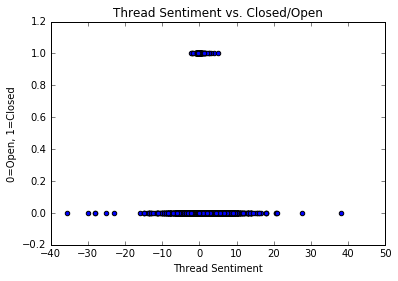

In [51]:
plt.scatter(threaddf['thread_sent'],threaddf['closed'])
plt.xlabel('Thread Sentiment')
plt.ylabel('0=Open, 1=Closed')
plt.title('Thread Sentiment vs. Closed/Open')

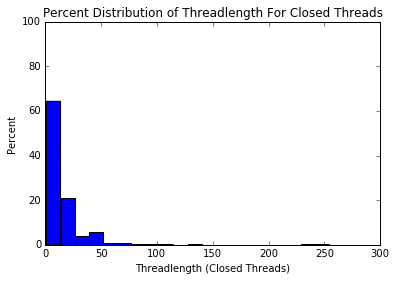

In [52]:
plt.hist(threaddf[threaddf['closed']==1]['threadlength'], 
         bins = 20, weights= np.zeros_like(threaddf[threaddf['closed']==1]['threadlength'])
         +100.0/threaddf[threaddf['closed']==1]['threadlength'].size)

plt.xlabel('Threadlength (Closed Threads)')
plt.ylabel('Percent')
plt.ylim((0,100))
plt.title('Percent Distribution of Threadlength For Closed Threads')

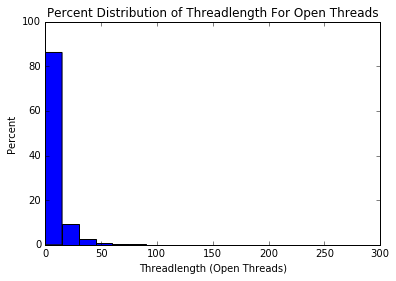

In [53]:

plt.hist(threaddf[threaddf['closed']==0]['threadlength'], range = (0,300), 
         bins = 20, weights= np.zeros_like(threaddf[threaddf['closed']==0]['threadlength'])
         +100.0/threaddf[threaddf['closed']==0]['threadlength'].size)

plt.xlabel('Threadlength (Open Threads)')
plt.ylabel('Percent')
plt.ylim((0,100))
plt.title('Percent Distribution of Threadlength For Open Threads')

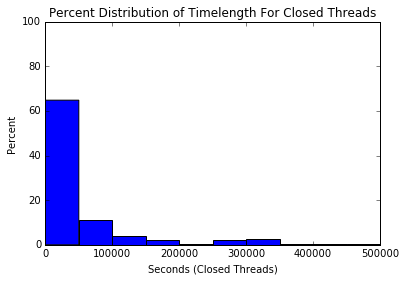

In [54]:
threadtime = threaddf[threaddf['closed']==1]['timelength'].apply(lambda x: x.total_seconds())

plt.hist(threadtime, range = (0,500000), weights= np.zeros_like(threadtime)+100.0/threadtime.size)

plt.xlabel('Seconds (Closed Threads)')
plt.ylabel('Percent')
plt.ylim((0,100))
plt.title('Percent Distribution of Timelength For Closed Threads')

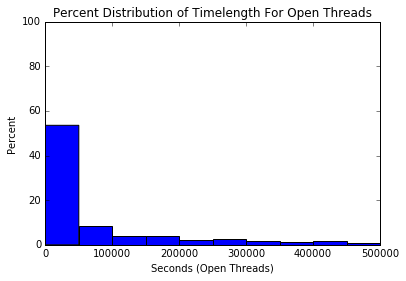

In [55]:
threadtime = threaddf[threaddf['closed']==0]['timelength'].apply(lambda x: x.total_seconds())

plt.hist(threadtime, range = (0,500000), weights= np.zeros_like(threadtime)+100.0/threadtime.size)

plt.xlabel('Seconds (Open Threads)')
plt.ylabel('Percent')
plt.ylim((0,100))
plt.title('Percent Distribution of Timelength For Open Threads')

/Users/Devoe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


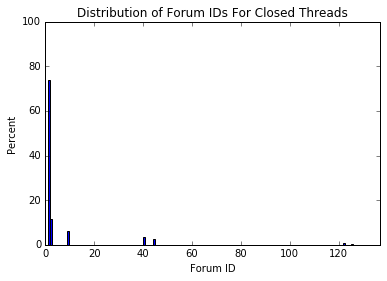

In [56]:
forum_id_closed = threaddf[threaddf['closed']==1].sort('forum_id')['forum_id']
forum_id_closed_prct = forum_id_closed.value_counts()/forum_id_closed.value_counts().sum()*100

plt.bar(forum_id_closed.unique(), forum_id_closed_prct)

plt.xlabel('Forum ID')
plt.xlim((0,137))
plt.ylabel('Percent')
plt.ylim((0,100))
plt.title('Distribution of Forum IDs For Closed Threads')

/Users/Devoe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


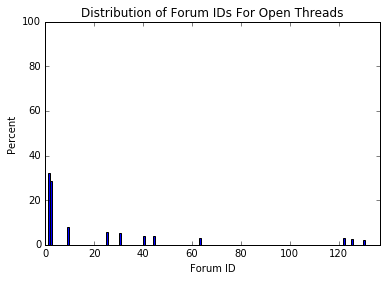

In [57]:
forum_id_open = threaddf[threaddf['closed']==0].sort('forum_id')['forum_id']
forum_id_open_prct = forum_id_open.value_counts()/forum_id_open.value_counts().sum()*100

plt.bar(forum_id_open.unique(), forum_id_open_prct)

plt.xlabel('Forum ID')
plt.xlim((0,137))
plt.ylabel('Percent')
plt.ylim((0,100))
plt.title('Distribution of Forum IDs For Open Threads')

In [58]:
# Percent of threads that were closed with a negative sentiment rating

len(threaddf[(threaddf['closed']==1)&(threaddf['thread_sent']<0)])/float(len(threaddf[threaddf['closed']==1]))*100

49.48979591836735

In [59]:
# Percent of threads that were open with a negative sentiment rating

len(threaddf[(threaddf['closed']==0)&(threaddf['thread_sent']<0)])/float(len(threaddf[threaddf['closed']==0]))*100

22.82844733984799

# Modeling

In [60]:
# Closed thread counts

threaddf[threaddf['closed']==1].count()

subject             196
forum_id            196
timelength          196
threadlength        196
post_per_sec        196
most_common_user    196
closed              196
thread_sent         196
dtype: int64

In [61]:
# Open thread counts

threaddf[threaddf['closed']==0].count()

subject             88416
forum_id            88416
timelength          88416
threadlength        88416
post_per_sec        88416
most_common_user    88416
closed              88416
thread_sent         88416
dtype: int64

In [62]:
# Percent distribution of posts in forums among Open threads. (forum_id is on the left)

forum_id_open_prct

1      32.258867
2      28.406623
40      7.940870
30      5.860930
9       5.133686
125     3.883912
122     3.774204
63      3.184944
130     3.164586
25      2.728013
137     2.288047
44      1.375317
Name: forum_id, dtype: float64

In [64]:
# We have a huge class imbalance, so we need to sample from the Open threads so we 
# at least balance our classes out. Not only that, but so that our sample matches its population,
# we need to take a probability sample of the open threads, so that our sample has the same 
# post distribution among the forums as the population. 

fid_sample_n = {'1.0':64, '2.0':56, '40.0':16, '30.0':12, '9.0':10, '125.0':8, '122.0':8, '63.0':6, '130.0':6, 
                '25.0':6, '137.0':4, '44.0':4}
open_thread_sample = pd.DataFrame()

for fid, num in fid_sample_n.iteritems():
    open_thread_sample = open_thread_sample.append(threaddf[threaddf['forum_id']==float(fid)].sample(n=num, random_state = 9))

open_thread_sample[open_thread_sample['forum_id']==40.0].count()

subject             16
forum_id            16
timelength          16
threadlength        16
post_per_sec        16
most_common_user    16
closed              16
thread_sent         16
dtype: int64

In [65]:
# Combine the open thread prob sample with all the closed thread data. We should have 200 if all worked well.

threaddf_sample = threaddf.drop(threaddf[threaddf['closed']==0].index).append(open_thread_sample)
threaddf_sample[threaddf_sample['closed']==0].count()

subject             200
forum_id            200
timelength          200
threadlength        200
post_per_sec        200
most_common_user    200
closed              200
thread_sent         200
dtype: int64

In [66]:
threaddf.head()

,subject,forum_id,timelength,threadlength,post_per_sec,most_common_user,closed,thread_sent
0,\r\n Auto Loan Calculators\r\n,1,00:00:01,1,1.0,unmatagak,0,-1.0
1,\r\nChase & Status - The Breezeblock Mix 12/20...,125,00:00:01,1,1.0,myfb,0,1.0
2,\r\nCompaq Netbook Best Buy\r\n,1,00:00:01,1,1.0,mefemismmaf,0,1.5
3,\r\nFree Agent- Calibre Mix,125,00:00:01,1,1.0,myfb,0,0.0
4,\r\nLoxy & Ink- The Horseman Apocalypse\r\n,125,00:00:01,1,1.0,myfb,0,0.0


In [67]:
#Convert timelength to integer seconds

threaddf_sample['timelength'] = threaddf_sample['timelength'].astype('timedelta64[s]').astype(int)
threaddf_sample.head()

,subject,forum_id,timelength,threadlength,post_per_sec,most_common_user,closed,thread_sent
307,ATTENTION: ‘Give’ (Nick) assaulted his ex-gir...,1,95221,63,0.000662,4_.phrantek._4,1,-0.563492
308,ATTENTION: ‘Give’ (Nick) assaulted his ex-gir...,1,2878,3,0.001042,jos,1,0.333333
410,DJ/ MC battle who wants to see one?,2,2807,21,0.007481,phish78,1,-0.190476
450,FAKE ASS WEB DESIGNER's FINAL PLEA www.digita...,1,1922888,17,0.000009,ghetto_dave,1,0.117647
451,FAKE ASS WEB DESIGNER's FINAL PLEA www.digita...,1,1,1,1.000000,outsource,1,-1.000000


In [71]:
# Create independent, dependent variables

X = threaddf_sample.drop(['closed', 'most_common_user', 'subject', 'forum_id'], axis = 1).reset_index()
y = threaddf_sample.closed.reset_index()

In [72]:
# Cleaning up X

X = X.drop('index', axis = 1)
X.head()

,timelength,threadlength,post_per_sec,thread_sent
0,95221,63,0.000662,-0.563492
1,2878,3,0.001042,0.333333
2,2807,21,0.007481,-0.190476
3,1922888,17,0.000009,0.117647
4,1,1,1.000000,-1.000000


In [73]:
# Cleaning up y

y = y.drop('index', axis = 1)
y.head()

,closed
0,1
1,1
2,1
3,1
4,1


In [74]:
# Train-test splits

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 9)

In [75]:
# Some features have large ranges, so we create another train-test split, but with a log() function applied to them.
# This may help our modeling down the road.

threaddf_sample2 = threaddf_sample
threaddf_sample2.head()

,subject,forum_id,timelength,threadlength,post_per_sec,most_common_user,closed,thread_sent
307,ATTENTION: ‘Give’ (Nick) assaulted his ex-gir...,1,95221,63,0.000662,4_.phrantek._4,1,-0.563492
308,ATTENTION: ‘Give’ (Nick) assaulted his ex-gir...,1,2878,3,0.001042,jos,1,0.333333
410,DJ/ MC battle who wants to see one?,2,2807,21,0.007481,phish78,1,-0.190476
450,FAKE ASS WEB DESIGNER's FINAL PLEA www.digita...,1,1922888,17,0.000009,ghetto_dave,1,0.117647
451,FAKE ASS WEB DESIGNER's FINAL PLEA www.digita...,1,1,1,1.000000,outsource,1,-1.000000


In [76]:
X_train.head()

,timelength,threadlength,post_per_sec,thread_sent
294,4669827,5,1.070703e-06,0.200000
9,59868463,35,5.846150e-07,0.114286
352,1,1,1.000000e+00,0.000000
54,10006,11,1.099340e-03,0.045455
179,117973,12,1.017182e-04,-1.666667


In [77]:
threaddf_sample2['timelength'] = np.log(threaddf_sample['timelength'])
threaddf_sample2['post_per_sec'] = np.log(threaddf_sample['post_per_sec'])

In [78]:
# Second log() set of data

X2 = threaddf_sample2.drop(['closed', 'most_common_user', 'subject'], axis = 1).reset_index()
X2 = X2.drop('index', axis = 1)
y2 = threaddf_sample2.closed.reset_index()
y2 = y2.drop('index', axis = 1)

In [79]:
X2.head()

,forum_id,timelength,threadlength,post_per_sec,thread_sent
0,1,11.463956,63,-7.320821,-0.563492
1,1,7.964851,3,-6.866239,0.333333
2,2,7.939872,21,-4.895349,-0.190476
3,1,14.469339,17,-11.636125,0.117647
4,1,0.000000,1,0.000000,-1.000000


In [80]:
# Logged data train-test split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 9)

In [81]:
X_train.head()

,timelength,threadlength,post_per_sec,thread_sent
294,4669827,5,1.070703e-06,0.200000
9,59868463,35,5.846150e-07,0.114286
352,1,1,1.000000e+00,0.000000
54,10006,11,1.099340e-03,0.045455
179,117973,12,1.017182e-04,-1.666667


In [82]:
X_train2.head()

,forum_id,timelength,threadlength,post_per_sec,thread_sent
294,2,15.356633,5,-13.747195,0.200000
9,1,17.907660,35,-14.352312,0.114286
352,122,0.000000,1,0.000000,0.000000
54,1,9.210940,11,-6.813045,0.045455
179,1,11.678211,12,-9.193304,-1.666667


In [83]:
X_test.head()

,timelength,threadlength,post_per_sec,thread_sent
308,111305472,35,3.144499e-07,0.471429
57,1,1,1.000000e+00,-0.500000
109,19059,7,3.672805e-04,-0.071429
2,2807,21,7.481297e-03,-0.190476
97,1,1,1.000000e+00,0.500000


In [84]:
X_test2.head()

,forum_id,timelength,threadlength,post_per_sec,thread_sent
308,2,18.527789,35,-14.972441,0.471429
57,1,0.000000,1,0.000000,-0.500000
109,1,9.855295,7,-7.909385,-0.071429
2,2,7.939872,21,-4.895349,-0.190476
97,1,0.000000,1,0.000000,0.500000


In [85]:
y_train.head()

,closed
294,0
9,1
352,0
54,1
179,1


In [86]:
y_train2.head()

,closed
294,0
9,1
352,0
54,1
179,1


## Naive Bayes (GaussianNB)

In [87]:
# testing accuracy of Gaussian Naive Bayes on first test set

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_class = gnb.predict(X_test)
print metrics.accuracy_score(y_test, y_pred_class)

0.464646464646


/Users/Devoe/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
# Confusion Matrix

print metrics.confusion_matrix(y_test, y_pred_class)

[[46  3]
 [50  0]]


In [89]:
# Accuracy

print metrics.roc_auc_score(y_test, y_pred_class)

0.469387755102


In [90]:
# testing accuracy of Gaussian Naive Bayes on logged dataset

gnb2 = GaussianNB()
gnb2.fit(X_train2, y_train2)
y_pred_class2 = gnb2.predict(X_test2)
print metrics.accuracy_score(y_test2, y_pred_class2)

0.545454545455


/Users/Devoe/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [91]:
# Confusion Matrix

print metrics.confusion_matrix(y_test2, y_pred_class2)

[[42  7]
 [38 12]]


In [92]:
# Accuracy

print metrics.roc_auc_score(y_test2, y_pred_class2)

0.548571428571


## Logistic Regression Model

In [93]:
# Logistic Regression Model

lrm = LogisticRegression()

lrm_cv = GridSearchCV(estimator=lrm, param_grid={'C': [10**-i for i in range(-10, 10)]}, scoring = 'roc_auc', cv = 5)

lrm_cv.fit(X_train.values, y_train['closed'].values)

print "Best Params: ",lrm_cv.best_params_

print "Best estimator: ",lrm_cv.best_estimator_

print "Best Roc_Auc Score: ",lrm_cv.best_score_


Best Params:  {'C': 10000000000}
Best estimator:  LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Best Roc_Auc Score:  0.449058000597


## Support Vector Machines w/ GridSearchCV

In [95]:
# Support Vector Machines Model

from sklearn import preprocessing

svc = SVC()

#param_grid = [
# {'C': [1, 10, 100], 'kernel': ['linear']},
# {'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}]

svc_cv = GridSearchCV(estimator = svc, param_grid = {'C':10, 'Kernel':'linear'}, scoring = 'roc_auc', cv = 5)

svc_cv.fit(X_train.values, y_train['closed'].values)

print "Best Params: ",svc.best_params_ 

print "Best estimator: ",svc.best_estimator_

print "Best Roc_Auc Score: ",svc.best_score_


 Best Params: 

AttributeError: 'SVC' object has no attribute 'best_params_'

## Random Forest w/ GridSearchCV

In [101]:
# Random Forest with GridSearchCV

rfm = RandomForestClassifier()

param_grid = {'n_estimators':[20,200], 'max_features':['auto', 'sqrt','log2']}

cv_rfm = GridSearchCV(estimator = rfm, param_grid = param_grid, cv = 6, scoring = 'roc_auc')
cv_rfm.fit(X_train.values, y_train['closed'].values)

print "Best Params: ",cv_rfm.best_params_

print "Best estimator: ",cv_rfm.best_estimator_

print "Best Roc_Auc Score: ",cv_rfm.best_score_




Best Params:  {'max_features': 'auto', 'n_estimators': 20}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best Roc_Auc Score:  0.725485625486


In [102]:
# Best estimator

best_rfm = cv_rfm.best_estimator_

In [103]:
# Feature Importances

feature_importances = best_rfm.feature_importances_
feature_names = X_train.columns.values
feature_imp_df = pd.DataFrame({'Features':feature_names, 'Importance':feature_importances})
feature_imp_df

,Features,Importance
0,timelength,0.205862
1,threadlength,0.204113
2,post_per_sec,0.266409
3,thread_sent,0.323616


In [104]:
# Create prediction values for Random Forest 

rfm_predict = best_rfm.predict(X_test)

In [105]:
# Calculate Random Forest model accuracy

rfm_accuracy = metrics.accuracy_score(y_test, rfm_predict)
rfm_accuracy

0.68686868686868685

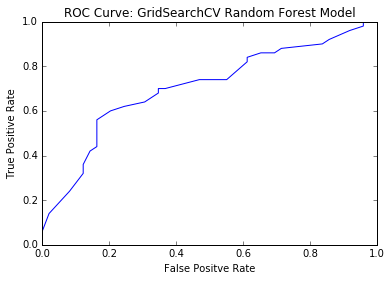

In [106]:
# ROC Curve for Random Forest Model

rfm_probas = best_rfm.predict_proba(X_test)
plt.plot(roc_curve(y_test, rfm_probas[:,1])[0], roc_curve(y_test, rfm_probas[:,1])[1])
plt.xlabel('False Positve Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GridSearchCV Random Forest Model')

In [107]:
# Classification Report for Random Forest model

classification_report(y_test, rfm_predict)

'             precision    recall  f1-score   support\n\n          0       0.66      0.76      0.70        49\n          1       0.72      0.62      0.67        50\n\navg / total       0.69      0.69      0.69        99\n'

In [133]:
# Can we beat the Random Forest with the logged data?

rfm2 = RandomForestClassifier()

param_grid2 = {'n_estimators':[20,200], 'max_features':['auto', 'sqrt','log2']}

cv_rfm2 = GridSearchCV(estimator = rfm2, param_grid = param_grid2, cv = 6, scoring = 'roc_auc')
cv_rfm2.fit(X_train2.values, y_train2['closed'].values)

print "Best Params: ",cv_rfm2.best_params_

print "Best estimator: ",cv_rfm2.best_estimator_

print "Best Roc_Auc Score: ",cv_rfm2.best_score_

Best Params:  {'max_features': 'log2', 'n_estimators': 200}
Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Best Roc_Auc Score:  0.786007726841


### Random Forest model fit to the logged data has about the same performance

In [134]:
# Best estimator

best_rfm2 = cv_rfm2.best_estimator_

In [135]:
# Feature Importances

feature_importances2 = best_rfm2.feature_importances_
feature_names = X_train.columns.values
feature_imp_df2 = pd.DataFrame({'Features':feature_names, 'Importance':feature_importances2})
feature_imp_df2

,Features,Importance
0,forum_id,0.215910
1,timelength,0.167819
2,threadlength,0.163827
3,post_per_sec,0.205185
4,thread_sent,0.247259


In [136]:
# Create prediction values for Random Forest 

rfm_predict2 = best_rfm2.predict(X_test2)

In [137]:
# Calculate Random Forest model accuracy

rfm_accuracy2 = metrics.accuracy_score(y_test2, rfm_predict2)
rfm_accuracy2

0.70707070707070707